<h3><b>Introduction to Data Analytics - Exercise set 4, exercise 1</b></h3>
<h4><b>Bakery dataset</b></h4>
<img src="http://srv.plab.fi/~tuomasv/data_analytics_2023_images/exercise_set_4/bakery.png" />

<b>Tip:</b> You can just click "Run All" to see the results of this notebook. Some of these exercises have some heavy plots that can take even 1 minute to produce.

<b>Remember:</b> not every dataset has interesting correlations and/or features (too much randomness or variance usually, or not enough data). Also, not each correlation implies there's a causation. Finally, not every plot is useful, that's why it's important to try multiple plots in order to "see under the hood". Typically pair plots, joint plots, regression plots, heatmaps and box plots are most useful, but there are some exceptions too.

<h3><b>Quick summary of data:</b></h3>

<p>This data contains a sample of a French bakery sales data from years 2021 and 2022. The data for 2022 is not complete for the last part of the year. The data is also separated by the time of day the bakery product (article) was sold as well the name of the product.</p>
<p>If you want to inspect the data seaborn mostly uses, check the DataFrame called "values" in the code. Please note there is a helper column called "article-time_of_day", whose only purpose is to allow use to do some extra analysis with seaborn later.</p>

<p>Kaggle page: <a href="https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales">https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales</a></p>

<h3><b>Questions for this exercise:</b></h3>
<b>Answer the questions either as code comments or as markdown. Use separate cells to write your answers.</b><br/><br/>
<li>There is one article (bakery product) that clearly stands out, and it also applies to a certain time of day. <br /><b>What is this article, and what could possibly be the reason for this?</b> (You might need Google and/or cultural knowledge to think about this question).</li>
<li>There is also another product that has increased in popularity more than others, what is this article? (you can also Google what it actually is if you're unfamiliar with it)</li>
<li>Which seaborn plots are useful in this notebook, and which are not? Why? (you can remove the unnecessary plots from this notebook if you wish too)</li>
<li>Which are more useful in this case, correlations or plots? Or are they both useful?</li>

<b>Extra questions/tasks for extra points:</b>
<li>If you find new insight or features in this dataset by using some other plots and/or pandas tricks, you can do so. In that case, please create a new section for the needed code cells you created accompanied with either code comments or markdown.  </li>
<li>Any other ideas about this dataset? Any ways to expand or improve the dataset and the analysis?</li>
<li>This notebook mostly concentrates on top 20% articles in the dataset. You can also inspect different regions of data, for example articles that are midrange in the dataset (quantile 20-50%). </li>


<hr />

<b style="color: red;">Place your answers here!</b>

<hr />

<h4><b>Imports and load the original dataset</b></h4>

In [2]:
# import the common data analytics modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<h4><b>Helper functions for dataset cleaning</b></h4>

In [3]:
# helper function for pandas, that allows changing the time
# column into nominal category (Morning, Afternoon, Evening)
def assign_day_time(row):
    # get the hour
    time = row['time'].split(":")
    hour = int(time[0])
    
    # due to common acknowledgments on what 
    # defines a Morning, Afternoon or Evening
    if 5 <= hour <= 12:
        return "Morning"
    elif 12 < hour <= 17:
        return "Afternoon"
    else:
        return "Evening"

<h4><b>Load the dataset and clean up data</b></h4>

In [4]:
# load the dataset and remove first column (some old index column)
df = pd.read_csv("bakery_dataset.csv")
df.pop(df.columns[0])

# we can see that some of the articles (type of bakery product)
# are very rare, we can focus on the more popular alternatives
article_counts = df['article'].value_counts()

# let's see the most common articles
print("Most common articles:")
print(article_counts)

# let's cut off at 1500. if there are articles sold less than that -> leave it out 
df = df[df['article'].map(df['article'].value_counts()) > 1500]

# this is a very common operation, split the date-column so
# that we can have months and years separately (much more useful for analysis)
df['year'] = df['date'].str.slice(0, 4).astype(int)
df['month'] = df['date'].str.slice(5, 7).astype(int)
df = df.drop('date', axis=1)

# drop also the ticket number, it's a reference/id -type of column
# and therefore not useful for analysis purposes
# the only case when an id-column is useful in data analytics is when
# you want to combine multiple datasets into one dataset, and the only data
# that connects one data to another is the id (for example product has a category id, 
# but the actual category data is stored in another dataset)
df = df.drop('ticket_number', axis=1)

# the price of the article/product is usable, but we have to clean it a little bit
# first of all, change comma (,) to period (.) as decimal separator
# and remove the €-sign, and finally convert the column into float-format
df['unit_price'] = df['unit_price'].str.replace(",", ".")
df['unit_price'] = df['unit_price'].str.replace("€", "").astype(float)

# create new column, the time of day (see function above)
# remove original time column after that 
df["time_of_day"] = df.apply(assign_day_time, axis=1)
df = df.drop("time", axis=1)

# let's see how balanced the years are
# more or less balanced, ~113000 for year 2021 and ~90000 for year 2022 
year_items = df['year'].value_counts()
print("\nYear distribution:")
print(year_items)

Most common articles:
article
TRADITIONAL BAGUETTE        67689
COUPE                       20470
BAGUETTE                    15292
BANETTE                     15130
CROISSANT                   11508
                            ...  
PAIN NOIR                       1
BUCHE 8PERS                     1
CRUMBLECARAMEL OU PISTAE        1
DOUCEUR D HIVER                 1
SACHET DE VIENNOISERIE          1
Name: count, Length: 149, dtype: int64

Year distribution:
year
2021    113687
2022     89085
Name: count, dtype: int64


In [5]:
# calculate total price based on quantity multiplied by price of single unit
# remove quantity and unit price columns after this
df['TotalPrice'] = df['Quantity'] * df['unit_price']
df = df.drop('Quantity', axis=1)
df = df.drop('unit_price', axis=1)

##################################################
## MORE ADVANCED PANDAS PREPARATION FOR SEABORN ##
##################################################

# even if we have reduced our articles to the cut off of 1500 pieces
# we still have quite too many article options in our data to do anything 

# one option is to use a feature called quantile with query
# quantile allows us to take a portion of the data based on the value distribution
# for example, top 10% or the values between 50-70% of the distribution.
# most commonly we are interested into highest values, mid-range values and lowest values

# first, take a copy of the dataframe, so we can preserve the original data
df_temp = df.copy()

# we need to drop the time of day so that we can find out the most common articles
df_temp = df_temp.drop('time_of_day', axis=1)

# group by articles and their total sums (quantity * units), and only take top 20% articles (quantile=0.8)
values = df_temp.groupby('article').sum().sort_values(by=['TotalPrice'], ascending=False)
df_highest = list(values.query('TotalPrice >= TotalPrice.quantile(q=0.80)').index)

# only filter the most common articles into a new dataframe
df_top = df[df['article'].isin(df_highest)]

# correlation matrices, one for all data and one for only top articles
correlations_original = df.corr(numeric_only=True)
correlations_top = df_top.corr(numeric_only=True)

# regroup data to article, time of day, year, month ... => grouped target value is TotalPrice
values = df_top.groupby(['article', 'time_of_day', 'year', 'month']).sum().sort_values(by=['TotalPrice'], ascending=False)
values = values.reset_index()

# new helper column with article name + time of day sold
# you'll notice later with seaborn why this is useful
# also rename the column so it doesn't confuse so much
values['article-time_of_day'] = values['article'] + "-" + values['time_of_day']
values = values.rename(columns={"TotalPrice": "TotalSales"})

<h4><b>seaborn plotting - pair plots</b></h4>

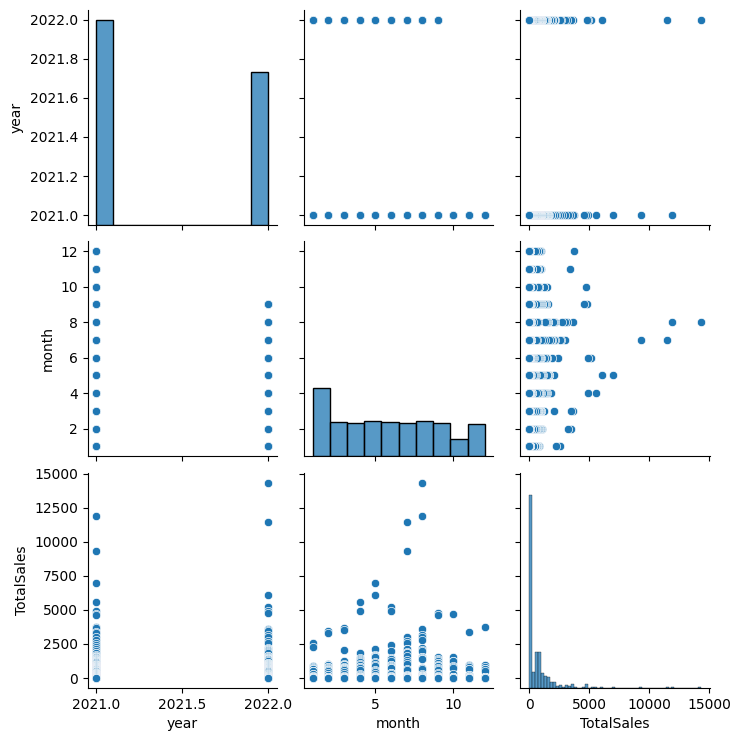

In [6]:
# basic pair plot
sns.pairplot(values)

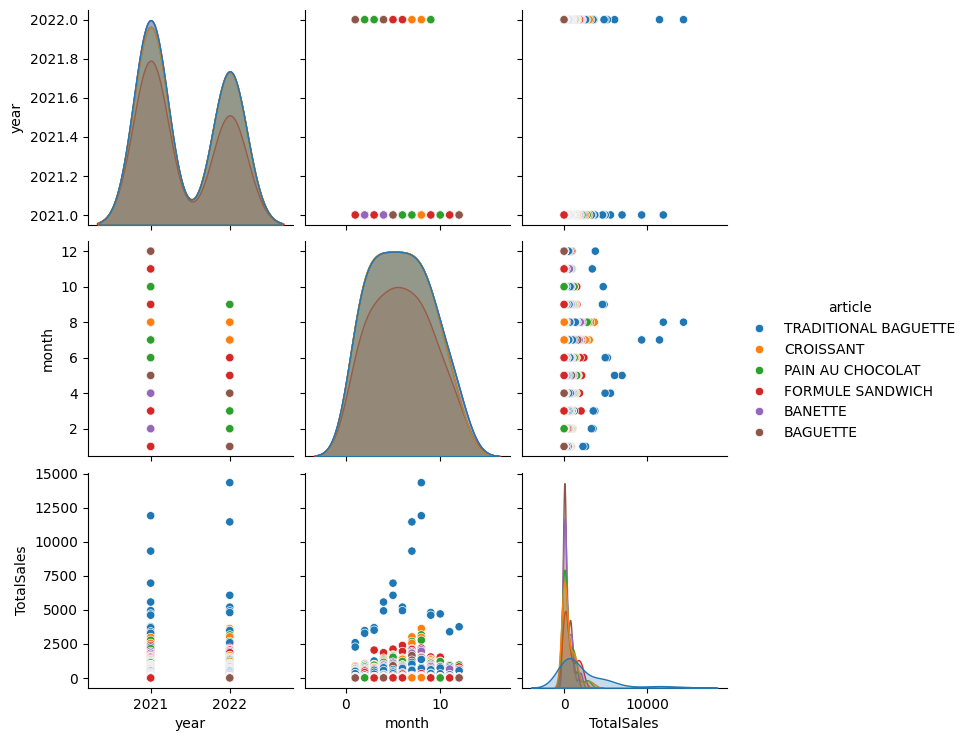

In [7]:
# pair plot, hue on article
sns.pairplot(values, hue="article")

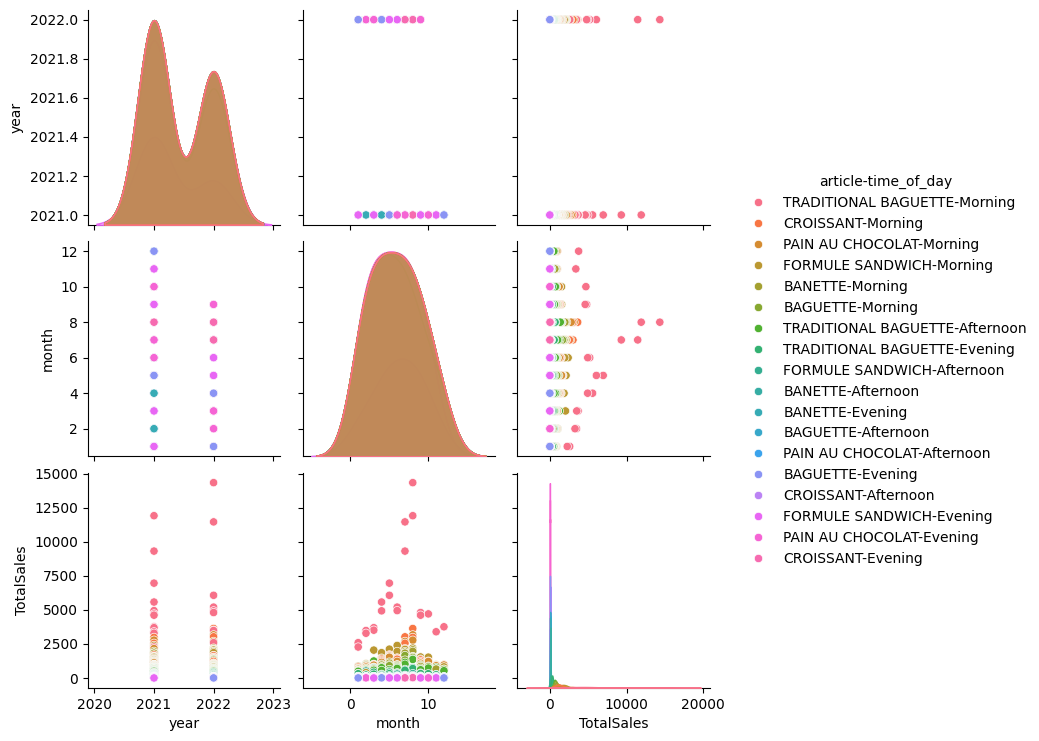

In [8]:
# pair plot, hue on article + time of day -combination
sns.pairplot(values, hue="article-time_of_day")

<h4><b>seaborn plotting - heatmaps</b></h4>

<Axes: >

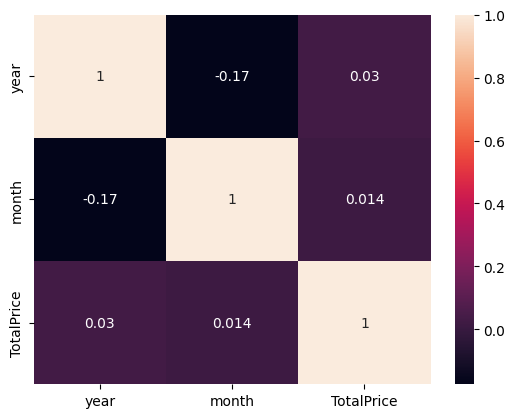

In [9]:
# heatmap for the whole dataset correlations
sns.heatmap(correlations_original, annot=True)

<Axes: >

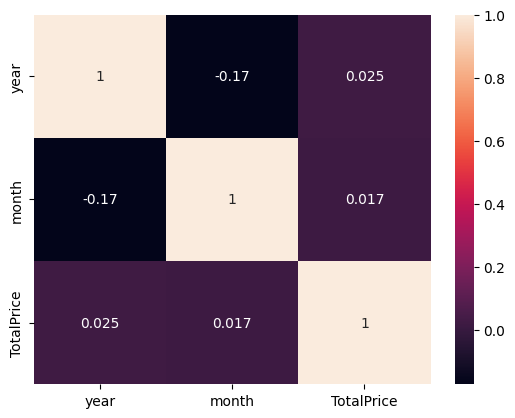

In [10]:
# heatmap for the top 20% articles correlations
sns.heatmap(correlations_top, annot=True)

<Axes: xlabel='year', ylabel='month'>

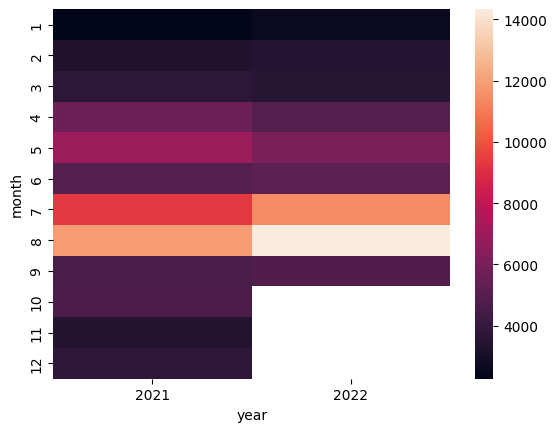

In [11]:
# heatmap for most popular article and its TotalSales
df_snippet = values[values['article-time_of_day'] == "TRADITIONAL BAGUETTE-Morning"]
pt = df_snippet.pivot_table(index='month', columns='year', values='TotalSales')
sns.heatmap(pt)

<Axes: xlabel='year', ylabel='month'>

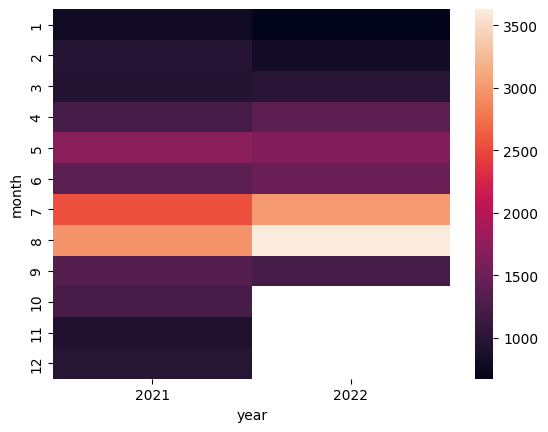

In [12]:
# heatmap for second most popular article and its TotalSales
df_snippet = values[values['article-time_of_day'] == "CROISSANT-Morning"]
pt = df_snippet.pivot_table(index='month', columns='year', values='TotalSales')
sns.heatmap(pt)

<Axes: xlabel='year', ylabel='month'>

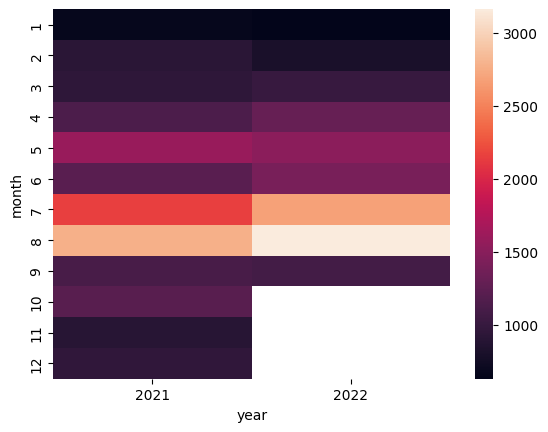

In [13]:
# heatmap for third most popular article and its TotalSales
df_snippet = values[values['article-time_of_day'] == "PAIN AU CHOCOLAT-Morning"]
pt = df_snippet.pivot_table(index='month', columns='year', values='TotalSales')
sns.heatmap(pt)

<Axes: xlabel='year', ylabel='month'>

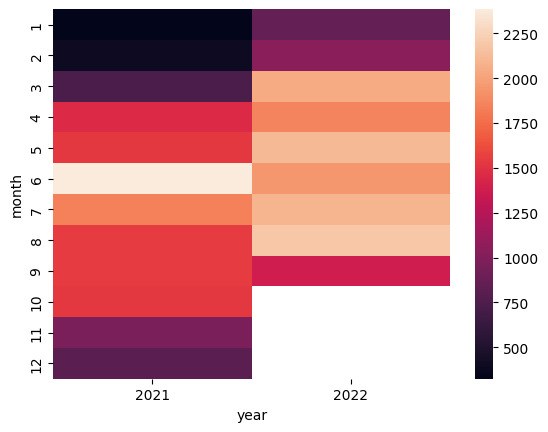

In [14]:
# heatmap for fourth most popular article and its TotalSales
df_snippet = values[values['article-time_of_day'] == "FORMULE SANDWICH-Morning"]
pt = df_snippet.pivot_table(index='month', columns='year', values='TotalSales')
sns.heatmap(pt)

<Axes: xlabel='year', ylabel='month'>

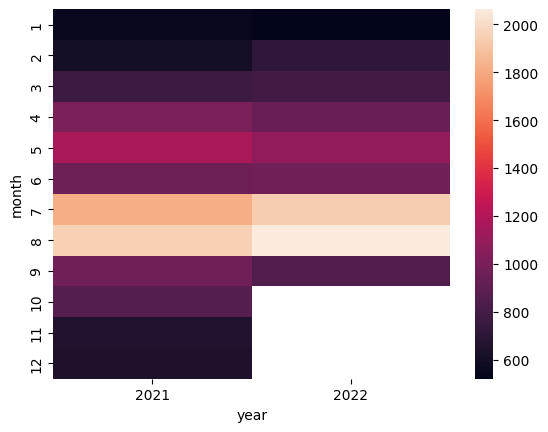

In [15]:
# heatmap for fifth most popular article and its TotalSales
df_snippet = values[values['article-time_of_day'] == "BANETTE-Morning"]
pt = df_snippet.pivot_table(index='month', columns='year', values='TotalSales')
sns.heatmap(pt)

<h4><b>seaborn plotting - regression plots</b></h4>

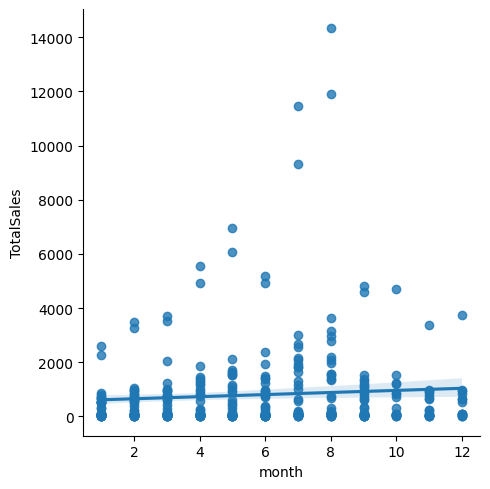

In [16]:
# regression plot for TotalSales
sns.lmplot(x='month', y='TotalSales', data=values)

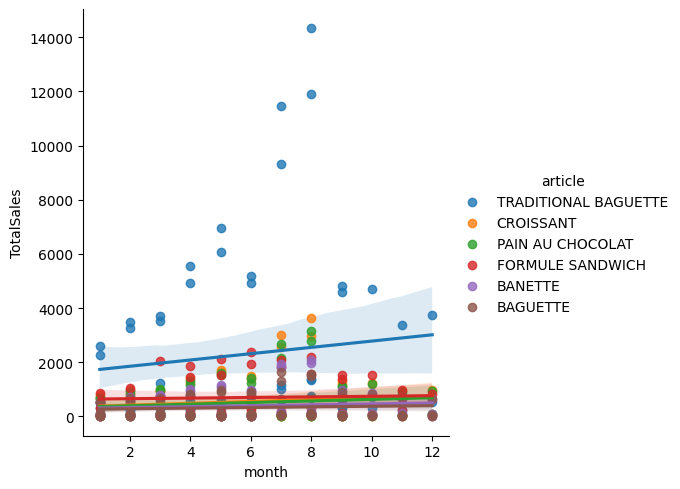

In [17]:
# regression plot for TotalSales, hue on article
sns.lmplot(x='month', y='TotalSales', data=values, hue='article')

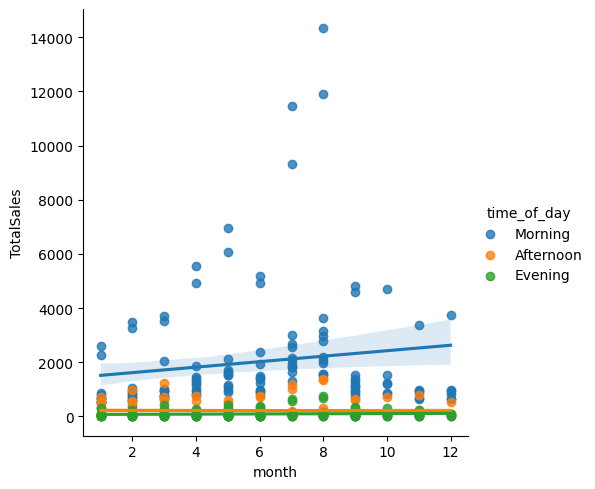

In [18]:
# regression plot for TotalSales, hue on time of day
sns.lmplot(x='month', y='TotalSales', data=values, hue='time_of_day')

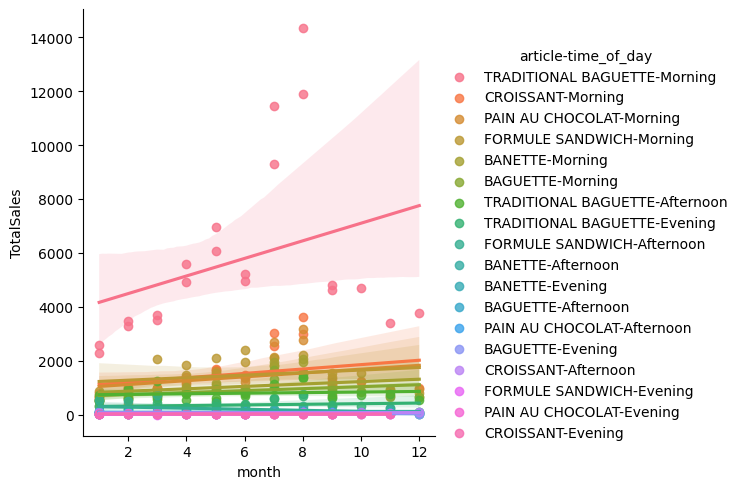

In [19]:
# regression plot for TotalSales, hue on article + time of day
sns.lmplot(x='month', y='TotalSales', data=values, hue='article-time_of_day')

<h4><b>seaborn plotting - box plots</b></h4>

<Axes: xlabel='year', ylabel='TotalSales'>

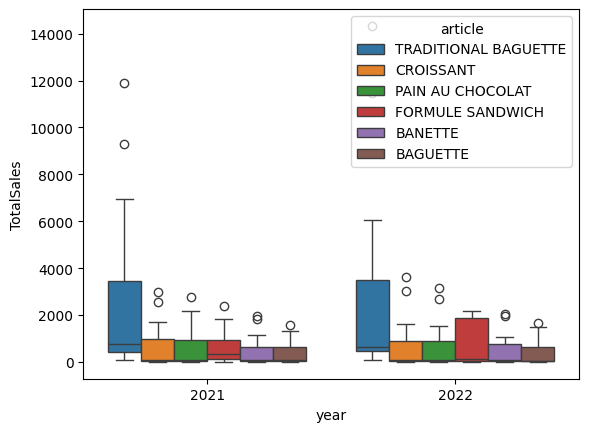

In [22]:
# box plot for TotalSales, hue on article
sns.boxplot(x='year', y='TotalSales', data=values, hue='article')

<Axes: xlabel='month', ylabel='TotalSales'>

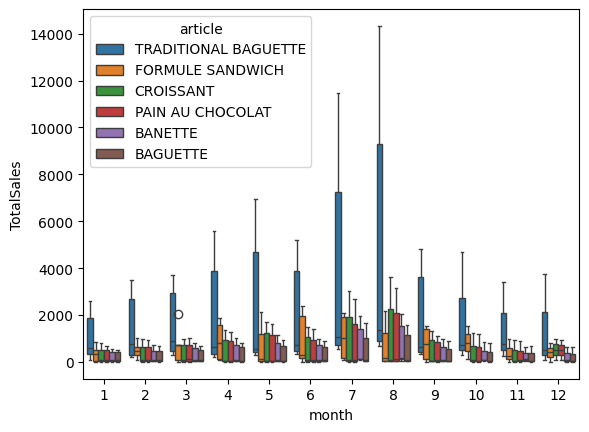

In [23]:
# box plot for TotalSales, hue on article
sns.boxplot(x='month', y='TotalSales', data=values, hue='article')

<Axes: xlabel='year', ylabel='TotalSales'>

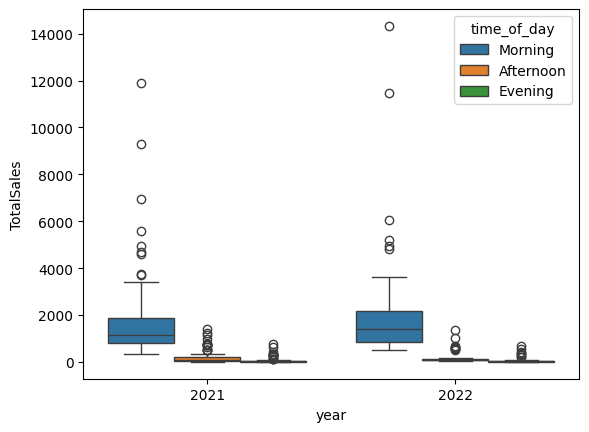

In [21]:
# box plot for TotalSales, hue on time of day
sns.boxplot(x='year', y='TotalSales', data=values, hue='time_of_day')

<Axes: xlabel='month', ylabel='TotalSales'>

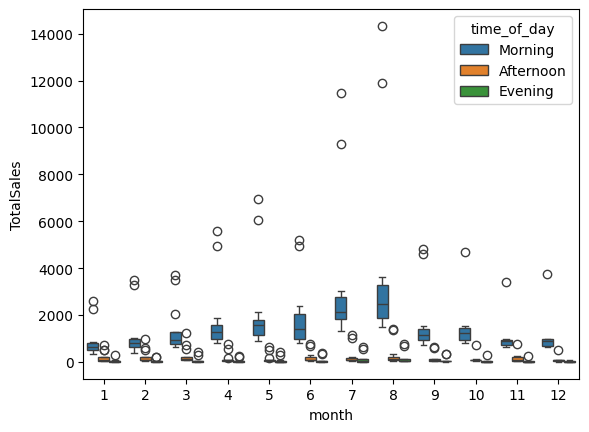

In [22]:
# box plot for TotalSales, hue on time of day
sns.boxplot(x='month', y='TotalSales', data=values, hue='time_of_day')

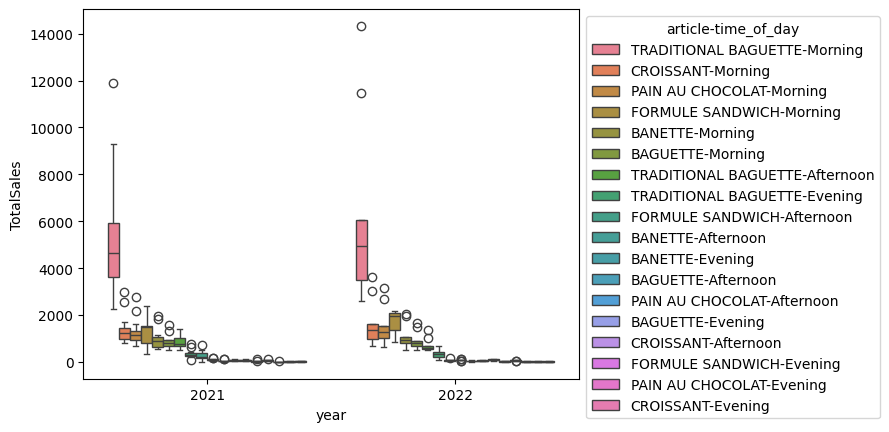

In [23]:
# box plot for TotalSales, hue on article + time of day
# move_legend is a nifty tool that moves the legend to other side
# if you have so many categories on hue that it hovers on data, making it difficult to see anything
ax = sns.boxplot(x='year', y='TotalSales', data=values, hue='article-time_of_day')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))